## AIM_ apply Hyperspy-pyxem filter to the InSe images

In [1]:
# Import all needed packages
import os
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import matplotlib
import mplcyberpunk
import scipy
import atomap
import atomap.api as am

from FunctionPackageOM import User_Functions, Ollis_Functions
from FunctionPackageOM.cepstral import browser
from FunctionPackageOM.Plot_Style import Plot_Style_OM_activate

# Load custom plot style
Plot_Style_OM_activate(white_bkg_for_visualization=True)

# Note: This line is specific to Jupyter Notebooks
# Uncomment if running in Jupyter
get_ipython().run_line_magic('matplotlib', 'ipympl')

# # Print the py4DSTEM version
# print(py4DSTEM.__version__)

In [2]:
## make overview of folder
fp = '/masc_shared/ag_volz/Oliver_Maßmeyer/InSe/InSe_Paper'
files = User_Functions.ListFilesFormatedSortedByTime(fp)

InSe_Paper/
    0: 002_B3338_C2055_Spot6C_CLA2_CL4cm_HR_layer_region1.dm3
    1: 003_B3338_C2055_Spot6C_CLA2_CL4cm_HR_sapphire.dm3
    2: 007_In_Layer.dm3
    3: pristine_copped.dm3
    4: Atomap
    5: CrystalModels
    6: FilteredImages
    7: TimeSeriesCropped
    8: Simulations
    9: 120751b InSe 1cm 20230913-104728-00226_gold.jpg
    10: 120751a_InSe2023090118010901098.jpg
    11: g27.png
    12: StackedImages
    13: g14137.png
    14: g14147.png
    15: g14160.png
    16: Images.svg


## Image 1

[<Axes: title={'center': 'Dark Field'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

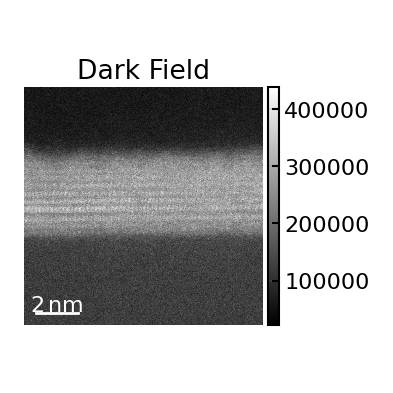

In [3]:

## load the data
fullFileName = os.path.join(fp, files[3]) # DF image
STEMImage = hs.load(fullFileName)
hs.plot.plot_images(STEMImage, tight_layout=True, axes_decor='off', cmap=['grey', 'grey'], label=['Dark Field', 'Bright Field'], scalebar='all')

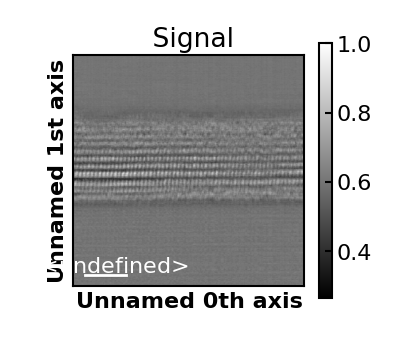

In [4]:
## apply atomap image filter 
STEMImageFiltered = atomap.main.run_image_filtering(STEMImage)
STEMImageFiltered.plot()

In [12]:
## save as hyperspy format
fsf = 'FilteredImages'
STEMImageFiltered.save(os.path.join(fp,fsf,'InSe_cropped_filtered.hspy'))

## Image 2

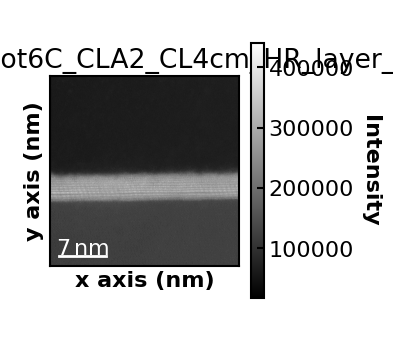

In [5]:
## load the data
fullFileName = os.path.join(fp, files[0]) # DF image
STEMImage = hs.load(fullFileName)
## use line roi to determine rotation angle
line_roi  = hs.roi.Line2DROI(5,5,10,10)
# r.gui()
STEMImage.plot()
roi1D = line_roi.interactive(STEMImage, color="yellow")

In [6]:
## set roation angle

# rotationAngle =  line_roi.angle()
rotationAngle = -0.6656600026070358
print("Rotation angle set to : ", rotationAngle)


Rotation angle set to :  -0.6656600026070358


[<Axes: title={'center': 'Dark Field'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

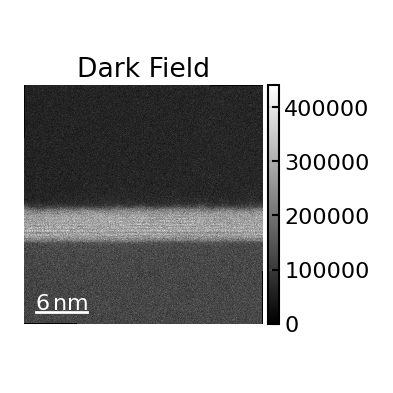

In [7]:
## rotate by angle

## add image rotation
STEMImage.data[:] = scipy.ndimage.rotate(STEMImage.data, angle=rotationAngle,
   reshape=False)

## crop 
margin = 5

STEMImage.crop_signal(
    top=margin,
    bottom=STEMImage.axes_manager[0].size-margin,
    left=margin,
    right=STEMImage.axes_manager[1].size-margin,
    convert_units=False,
)

hs.plot.plot_images(STEMImage, tight_layout=True, axes_decor='off', cmap=['grey', 'grey'], label=['Dark Field', 'Bright Field'], scalebar='all') 




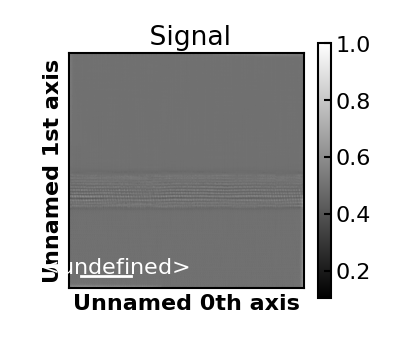

In [8]:
## apply atomap image filter 
STEMImageFiltered = atomap.main.run_image_filtering(STEMImage)
STEMImageFiltered.plot()

In [9]:
## apply calibraiton
STEMImageFiltered.axes_manager = STEMImage.axes_manager

In [24]:
## save as hyperspy format
fsf = 'FilteredImages'
STEMImageFiltered.save(os.path.join(fp,fsf,'InSe_filtered.hspy'))

Overwrite '/masc_shared/ag_volz/Oliver_Maßmeyer/InSe/InSe_Paper/FilteredImages/InSe_filtered.hspy' (y/n)?
 y


In [10]:
plt.close('all')

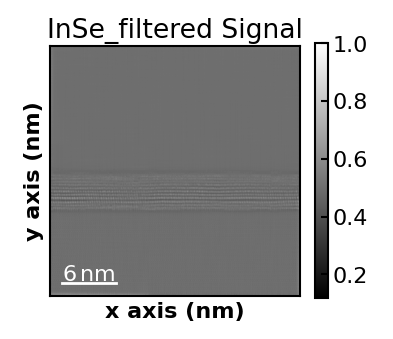

In [11]:
## load filtered data 
fsf = 'FilteredImages'
STEMImageFiltered = hs.load(os.path.join(fp,fsf,'InSe_filtered.hspy'))
STEMImageFiltered.plot()

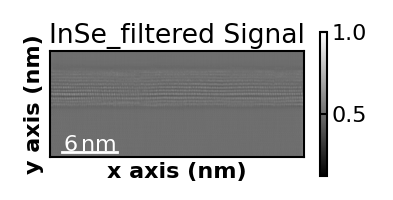

In [12]:
## crop before peak detectio
STEMImageFiltered.crop(1, 1800, 3500)
STEMImageFiltered.plot()

In [13]:
STEMImageFiltered

<Signal2D, title: , dimensions: (|4086, 1700)>

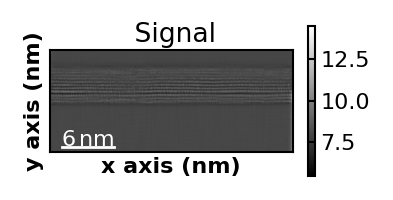

In [14]:
## bin for peak detection?
STEMImageFilteredBinned = STEMImageFiltered.rebin(scale=(4,4),crop=True)
STEMImageFilteredBinned.plot()


In [15]:
plt.close('all')

In [16]:
STEMImageFilteredBinned.axes_manager

Signal axis name,size,,offset,scale,units
x,1021,,0.044469851767644286,0.027366062626242638,nm
y,425,,12.359198033576831,0.027366062626242638,nm


In [85]:
## peak detection
s_peaks = am.get_feature_separation(STEMImageFilteredBinned,  pca = True,  subtract_background = True, normalize_intensity = True,threshold_rel=0.01, separation_range=(2, 5), show_progressbar=True)
s_peaks.plot()

  0%|          | 0/3 [00:00<?, ?it/s]

[########################################] | 100% Completed | 100.97 ms


In [17]:
## store the atom positions for the selected separation treshhold
atom_positions = am.get_atom_positions(STEMImageFilteredBinned, pca = True,  subtract_background = True, normalize_intensity = True,threshold_rel=0.01, separation=3)

In [18]:
## create sublattice from the selcted atoms

sublattice = am.Sublattice(atom_positions, image=STEMImageFilteredBinned.data, fix_negative_values=True)
sublattice

<Sublattice,  (atoms:5687,planes:0)>

In [19]:
## Position refinement using COM and then a 2D Gaussian fit

#need to find next-neighbour atoms to get boundaries for the refinement
sublattice.find_nearest_neighbors(nearest_neighbors=3)
sublattice.refine_atom_positions_using_center_of_mass(percent_to_nn=0.4)
sublattice.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.6)
# sublattice.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.4)
##plot with history
sublattice.get_position_history().plot()

Center of mass:   0%|          | 0/5687 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/5687 [00:00<?, ?it/s]

WARNING | Hyperspy | Covariance of the parameters could not be estimated. Estimated parameter standard deviations will be np.nan. (hyperspy.model:1447)
WARNING | Hyperspy | `m.fit()` did not exit successfully. Reason: Number of calls to function has reached maxfev = 1400. (hyperspy.model:1913)
WARNING | Hyperspy | Covariance of the parameters could not be estimated. Estimated parameter standard deviations will be np.nan. (hyperspy.model:1447)
WARNING | Hyperspy | `m.fit()` did not exit successfully. Reason: Number of calls to function has reached maxfev = 1400. (hyperspy.model:1913)
WARNING | Hyperspy | Covariance of the parameters could not be estimated. Estimated parameter standard deviations will be np.nan. (hyperspy.model:1447)
WARNING | Hyperspy | `m.fit()` did not exit successfully. Reason: Number of calls to function has reached maxfev = 1400. (hyperspy.model:1913)
WARNING | Hyperspy | Covariance of the parameters could not be estimated. Estimated parameter standard deviations w

In [20]:
sublattice.get_position_history().plot()

In [21]:
## get refined atom positions
refined_atom_positions = sublattice.atom_positions



In [23]:
##store fitted atom positions
fsf = 'Atomap' # define save folder
np.savetxt(os.path.join(fp,fsf ,'Fitted_Positions.txt'), refined_atom_positions)

In [24]:
## load the atom positions it already fitted:
atomPositions = np.loadtxt(os.path.join(fp,fsf ,'Fitted_Positions.txt'))


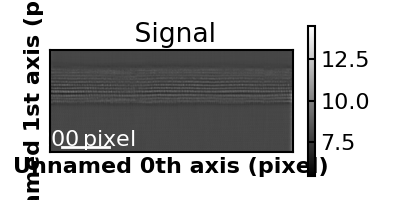

In [25]:
## visualize
sublattice = am.Sublattice(atomPositions, image=STEMImageFilteredBinned.data, fix_negative_values=True)
sublattice

## readout start postions
a = sublattice.get_atom_list_on_image(add_numbers=False, markersize =1) # 0
a.plot()

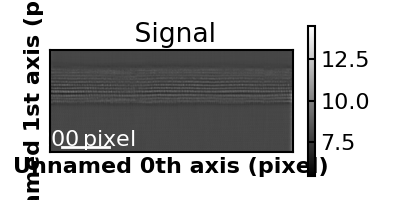

In [26]:
## filter for In row
col_crop_val_left = 0
col_crop_val_right = STEMImage.axes_manager[0].size
row_crop_val_up = 165
row_crop_val_down = 180

# row_crop_val_up = 165
# row_crop_val_down = 180

InPositions = Ollis_Functions.AtomapFilterCropAtomPositionList(atomPositions, col_crop_val_left, col_crop_val_right, row_crop_val_up, row_crop_val_down)

## create sublattice from the selcted atoms
sublatticeIn = am.Sublattice(InPositions, image=STEMImageFilteredBinned.data, fix_negative_values=True)
sublatticeIn

## readout start postions
a = sublatticeIn.get_atom_list_on_image(add_numbers=False, markersize =1) # 0
a.plot()


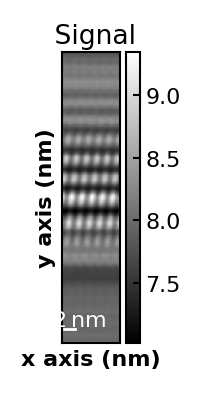

In [27]:
## average positions
imageStack, imageMean = Ollis_Functions.SuperSTEM_average_all_positions_subpixel_XYmargin(STEMImageFilteredBinned.data,InPositions,np.array([20,100]),1)
imageMean = hs.signals.Signal2D(imageMean)
#calibrate
imageMean.axes_manager[0].scale = STEMImageFilteredBinned.axes_manager[0].scale
imageMean.axes_manager[0].units = STEMImageFilteredBinned.axes_manager[0].units
imageMean.axes_manager[1].scale = STEMImageFilteredBinned.axes_manager[1].scale
imageMean.axes_manager[1].units = STEMImageFilteredBinned.axes_manager[1].units
imageMean.axes_manager[0].name = 'x'
imageMean.axes_manager[1].name = 'y'
imageMean.plot()

In [132]:
# store as hspy
fsf = 'StackedImages' # define save folder
imageMean.save(os.path.join(fp,fsf ,'MeanImageFiltered.hspy'))


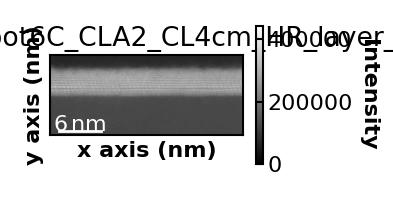

In [28]:
##crop STEM image
STEMImage.crop(1, 1800, 3500)
STEMImage.plot()


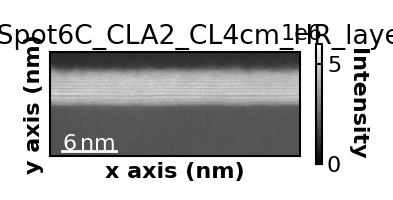

In [29]:
STEMImageBinned = STEMImage.rebin(scale=(4,4),crop=True)
STEMImageBinned.plot()

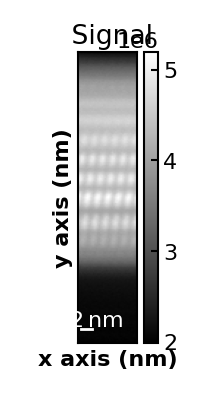

In [30]:
## average positions
imageStack, imageMean = Ollis_Functions.SuperSTEM_average_all_positions_subpixel_XYmargin(STEMImageBinned.data,InPositions,np.array([20,100]),1)
imageMean = hs.signals.Signal2D(imageMean)
#calibrate
imageMean.axes_manager[0].scale = STEMImageBinned.axes_manager[0].scale
imageMean.axes_manager[0].units = STEMImageBinned.axes_manager[0].units
imageMean.axes_manager[1].scale = STEMImageBinned.axes_manager[1].scale
imageMean.axes_manager[1].units = STEMImageBinned.axes_manager[1].units
imageMean.axes_manager[0].name = 'x'
imageMean.axes_manager[1].name = 'y'
imageMean.plot()


In [128]:
imageMean.axes_manager

Signal axis name,size,,offset,scale,units
x,40,,0.0,0.027366062626242638,nm
y,200,,0.0,0.027366062626242638,nm


In [130]:
# store as hspy
fsf = 'StackedImages' # define save folder
imageMean.save(os.path.join(fp,fsf ,'MeanImageUnfiltered.hspy'))


Overwrite '/masc_shared/ag_volz/Oliver_Maßmeyer/InSe/InSe_Paper/StackedImages/MeanImageUnfiltered.hspy' (y/n)?
 n


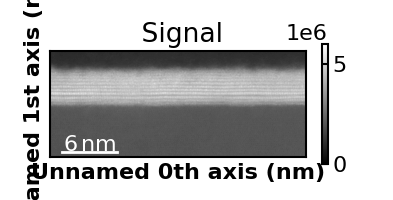

In [40]:
## for paper

## create sublattice from the selcted atoms
sublatticeIn2 = am.Sublattice(InPositions, image=STEMImageBinned, fix_negative_values=True)
sublatticeIn2

## readout start postions
a = sublatticeIn2.get_atom_list_on_image(add_numbers=False, markersize =0.2) # 0
a.plot()

## save to svg and png

save_to_svg_and_png = True

if save_to_svg_and_png:
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(os.path.join(fp,fsf,"PositionsForStacking_InSe.svg"),dpi = 300)
    plt.savefig(os.path.join(fp,fsf,"PositionsForStacking_InSe.png"),dpi = 300)



## stack on sapphire

In [41]:
## store the atom positions for the selected separation treshhold
atom_positions = am.get_atom_positions(STEMImageFilteredBinned, pca = True,  subtract_background = True, normalize_intensity = True,threshold_rel=0.01, separation=1)

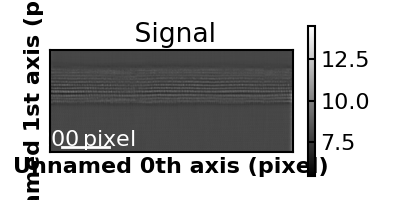

In [42]:
## stack on sapphire positions

## visualize
sublattice = am.Sublattice(atomPositions, image=STEMImageFilteredBinned.data, fix_negative_values=True)
sublattice

## readout start postions
a = sublattice.get_atom_list_on_image(add_numbers=False, markersize =1) # 0
a.plot()

In [43]:
## Position refinement using COM and then a 2D Gaussian fit
sublattice.find_nearest_neighbors(nearest_neighbors=3)
sublattice.refine_atom_positions_using_center_of_mass(percent_to_nn=0.4)
sublattice.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.6)


Center of mass:   0%|          | 0/5687 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/5687 [00:00<?, ?it/s]

WARNING | Hyperspy | Covariance of the parameters could not be estimated. Estimated parameter standard deviations will be np.nan. (hyperspy.model:1447)
WARNING | Hyperspy | `m.fit()` did not exit successfully. Reason: Number of calls to function has reached maxfev = 1400. (hyperspy.model:1913)
WARNING | Hyperspy | Covariance of the parameters could not be estimated. Estimated parameter standard deviations will be np.nan. (hyperspy.model:1447)
WARNING | Hyperspy | `m.fit()` did not exit successfully. Reason: Number of calls to function has reached maxfev = 1400. (hyperspy.model:1913)
WARNING | Hyperspy | Covariance of the parameters could not be estimated. Estimated parameter standard deviations will be np.nan. (hyperspy.model:1447)
WARNING | Hyperspy | `m.fit()` did not exit successfully. Reason: Number of calls to function has reached maxfev = 1400. (hyperspy.model:1913)
WARNING | Hyperspy | Covariance of the parameters could not be estimated. Estimated parameter standard deviations w

In [44]:
##plot with history
sublattice.get_position_history().plot()

In [45]:
refined_atom_positionsSapphire = sublattice.atom_positions

In [144]:
## save sapphire positions
fsf = 'Atomap' # define save folder
np.savetxt(os.path.join(fp,fsf ,'Fitted_Positions_Sapphire.txt'), refined_atom_positions)

In [46]:
## load the atom positions it already fitted:
atomPositions = np.loadtxt(os.path.join(fp,fsf ,'Fitted_Positions_Sapphire.txt'))

/home/massmeye/.conda/envs/py4DSTEMnewVersion/lib/python3.11/site-packages/hyperspy/drawing/utils.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**kwargs)


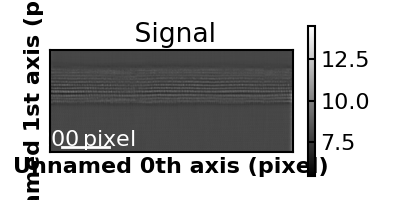

In [47]:
## visualize
sublattice = am.Sublattice(atomPositions, image=STEMImageFilteredBinned.data, fix_negative_values=True)
sublattice

## readout start postions
a = sublattice.get_atom_list_on_image(add_numbers=False, markersize =1) # 0
a.plot()

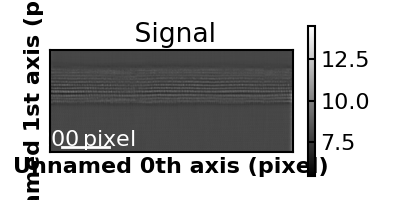

In [48]:
## filter for In row
col_crop_val_left = 0
col_crop_val_right = STEMImage.axes_manager[0].size
row_crop_val_up = 289
row_crop_val_down = 293

AlPositions = Ollis_Functions.AtomapFilterCropAtomPositionList(atomPositions, col_crop_val_left, col_crop_val_right, row_crop_val_up, row_crop_val_down)

## create sublattice from the selcted atoms
sublatticeAl = am.Sublattice(AlPositions, image=STEMImageFilteredBinned.data, fix_negative_values=True)
sublatticeAl

## readout start postions
a = sublatticeAl.get_atom_list_on_image(add_numbers=False, markersize =1) # 0
a.plot()


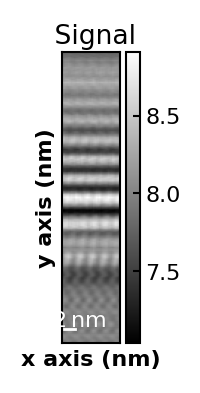

In [49]:
## average positions
shift = np.array([0,-120])
imageStack, imageMean = Ollis_Functions.SuperSTEM_average_all_positions_subpixel_XYmargin(STEMImageFilteredBinned.data,AlPositions+shift,np.array([20,100]),1)
imageMean = hs.signals.Signal2D(imageMean)
#calibrate
imageMean.axes_manager[0].scale = STEMImageFilteredBinned.axes_manager[0].scale
imageMean.axes_manager[0].units = STEMImageFilteredBinned.axes_manager[0].units
imageMean.axes_manager[1].scale = STEMImageFilteredBinned.axes_manager[1].scale
imageMean.axes_manager[1].units = STEMImageFilteredBinned.axes_manager[1].units
imageMean.axes_manager[0].name = 'x'
imageMean.axes_manager[1].name = 'y'
imageMean.plot()

In [164]:
# store as hspy
fsf = 'StackedImages' # define save folder
imageMean.save(os.path.join(fp,fsf ,'MeanImageFilteredSapphire.hspy'))

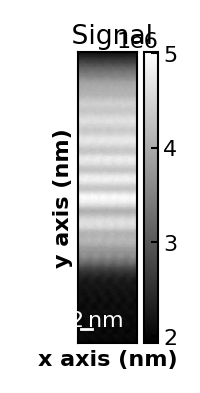

In [50]:
## average positions
shift = np.array([0,-120])
imageStack, imageMean = Ollis_Functions.SuperSTEM_average_all_positions_subpixel_XYmargin(STEMImageBinned.data,AlPositions+shift,np.array([20,100]),1)
imageMean = hs.signals.Signal2D(imageMean)
#calibrate
imageMean.axes_manager[0].scale = STEMImageFilteredBinned.axes_manager[0].scale
imageMean.axes_manager[0].units = STEMImageFilteredBinned.axes_manager[0].units
imageMean.axes_manager[1].scale = STEMImageFilteredBinned.axes_manager[1].scale
imageMean.axes_manager[1].units = STEMImageFilteredBinned.axes_manager[1].units
imageMean.axes_manager[0].name = 'x'
imageMean.axes_manager[1].name = 'y'
imageMean.plot()

In [166]:
# store as hspy
fsf = 'StackedImages' # define save folder
imageMean.save(os.path.join(fp,fsf ,'MeanImageUnfilteredSapphire.hspy'))

Overwrite '/masc_shared/ag_volz/Oliver_Maßmeyer/InSe/InSe_Paper/StackedImages/MeanImageUnfilteredSapphire.hspy' (y/n)?
 y


In [171]:
## save binned stem image
fsf = 'FilteredImages' # define save folder
STEMImageBinned.save(os.path.join(fp,fsf ,'STEMImageBinned.hspy'))

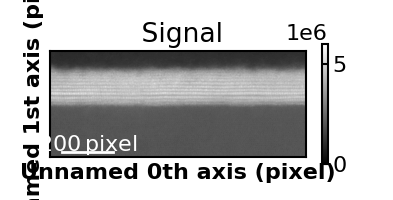

In [57]:
## for paper on experimental image
## create sublattice from the selcted atoms
sublatticeAl2 = am.Sublattice(AlPositions, image=STEMImageBinned.data, fix_negative_values=True)
sublatticeAl2

## readout start postions
a = sublatticeAl2.get_atom_list_on_image(add_numbers=False, markersize =0.2) # 0
a.plot()

## save to svg and png

save_to_svg_and_png = True

if save_to_svg_and_png:
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(os.path.join(fp,fsf,"PositionsForStacking_Al2O3.svg"),dpi = 300)
    plt.savefig(os.path.join(fp,fsf,"PositionsForStacking_Al2O3.png"),dpi = 300)


In [172]:
STEMImageBinned.axes_manager

Signal axis name,size,,offset,scale,units
x,1021,,0.044469851767644286,0.027366062626242638,nm
y,425,,12.359198033576831,0.027366062626242638,nm


In [ ]:
## 043

## load the data
fullFileName = os.path.join(fp, STEM_files[44]) # DF image
STEMImage = hs.load(fullFileName)
STEMImage.axes_manager.convert_units(units='um')

## add image rotation
STEMImage.data[:] = scipy.ndimage.rotate(STEMImage.data, angle=91,
   reshape=False)

## crop 
margin = 10
STEMImage.crop_signal(
    top=margin,
    bottom=STEMImage.axes_manager[0].size-margin,
    left=margin,
    right=STEMImage.axes_manager[1].size-margin,
    convert_units=False,
)

hs.plot.plot_images(STEMImage, tight_layout=True, axes_decor='off', cmap=['grey', 'grey'], label=['Dark Field', 'Bright Field'], scalebar='all') 

In [4]:
## import the image from dm3?
InSe = hs.load(os.path.join(fp,fn+'.dm3')) 


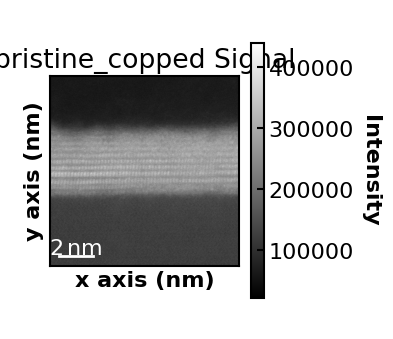

In [5]:
InSe.plot()